# 예제 - 문자 메시지 데이터에서 행동 추론하기

- 데이터
    - 일별 수신 문자 메시지 개수 (74일)
- 분석 가설
    - 사용자의 수신 문자 메시지 습관이 시간별로 **서서히 변하는지, 갑자기 급변하는지** 알고 싶음.
    - 서서히 변함(1 λ), 갑자기 급변(2 λ)

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pymc as pm

import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot

### 1) 사용자 문자 데이터 로드

In [13]:
# load data and count
msg = pd.read_csv('txtdata.csv', header = None)[0].values
n_msg = len(msg)
print(f'Observed data - {n_msg} 건')

Observed data - 74 건


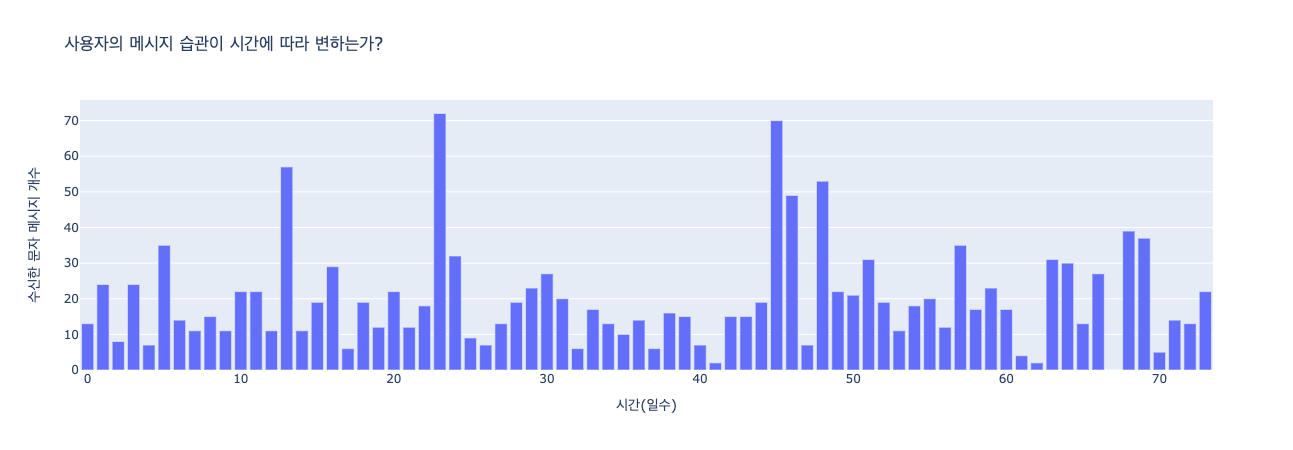

In [71]:
## plot 시간별 문자메시지 건 수
# trace
trace = go.Bar(
    y=msg,
    x=np.arange(0, len(msg))
)
# layout
layout=go.Layout(title=f"사용자의 메시지 습관이 시간에 따라 변하는가?", xaxis=dict(title='시간(일수)'), yaxis=dict(title='수신한 문자 메시지 개수'))
# fig(trace, layout)
fig = go.Figure(data=[trace], layout=layout)
# plot
iplot(fig)

### 2) 베이지안 데이터 모델링

- 포아송 랜덤 변수(Poisson Random Variable)는 시간에 따른 개수 데이터를 모델링하는데 가장 적합한 모델.
    - 단어 개수 모델링 (bm25)
    - 교통 사고 건수 모델링

### 베이지안 분석
#### 정의
- 랜덤 변수 $C_i$는 (i+1)일에 발생하는 메시지의 개수. ($i \in \{0,1,2,\cdots,73\}$)
- 랜덤 변수 $C_i$는 포아송 분포를 따른다. $C_i \sim Poisson(\lambda)$

#### 가설
- 관측기간에서 사용자의 문자 습관이 급변함.
    - 관측기간(0 ~ 73) 중, 특정 날짜(τ)에 랜덤 변수 $C_i$의 파라미터(λ)가 급변함($\lambda_1 \neq \lambda_2$).
    - 수학적으로 τ는 변환점(switch point)이라고 불린다.
- 만약 변환점이 존재하지 않으면, 사후확률분포의 파라미터(λ)는 동일함($\lambda_1 = \lambda_2$).
- 포아송 분포의 파라미터(λ)는 양의 실수이므로, 지수분포를 사전확률분포로 정의하는 것이 바람직.
    - $\lambda_1 \sim Exp(\alpha)$
    - $\lambda_2 \sim Exp(\alpha)$
    - 이 때, $\alpha$는 하이퍼파라미터 또는 부모변수(parent variable)로 불린다.
    - hyperparameter 튜닝을 하지 않을 경우 alpha는 데이터 평균의 역수로 정의
        $${1 \over N} \sum^{N}_{i=0}C_i \approx E[\lambda|\alpha] = {1 \over \alpha}$$
        - 지수분포의 기댓값과 동일하게...
        - 하이퍼파라미터의 영향력을 최소화
    - 서로 다른 람다 값을 가진 지수 분포 두 개를 만드는 것은 관측기간 중 어느 시점에서 비율이 변했다는 우리의 사전 믿음을 반영하는 것이다.
- τ는 사전확률을 알기 어려우므로 획일적인 사전 믿음을 할당함.(Uniform)
    - $\tau ~ DiscreteUniform(0, 73)$
    - $P(\tau = k) = {1 \over 74}$

### 3) pymc를 활용한 모델링

- 확률론적 변수 정의
    - $\lambda_1, \lambda_2, \tau$
    - pymc의 객체로 정의, 파라미터 값이 하이퍼파라미터로 정의된 분포에 따라서 난수발생으로 정의됨.
    - train 과정에서 최적의 tau 값을 찾는다.

In [81]:
# hyper-parameter
alpha = 1. / msg.mean()

# 사전확률 분포 정의
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_msg)

- 확률론적 변수 정의
    - $\lambda_1, \lambda_2, \tau$
    - pymc의 객체로 정의, 파라미터 값이 하이퍼파라미터로 정의된 분포에 따라서 난수발생으로 정의됨.
    - train 과정에서 최적의 tau 값을 찾는다.

In [82]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_msg)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

In [88]:
obsrevation = pm.Poisson('obs', lambda_, value=msg, observed=True)

In [89]:
model = pm.Model([obsrevation, lambda_1, lambda_2, tau])

In [90]:
mcmc = pm.MCMC(model)

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning:

Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.



In [92]:
iteration = 40000
burnout = 10000
# return 40000 - 10000
mcmc.sample(iteration, burnout)

 [-----------------100%-----------------] 40000 of 40000 complete in 6.9 sec

In [98]:
sampled_lambda_1 = mcmc.trace('lambda_1')[:]
sampled_lambda_2 = mcmc.trace('lambda_2')[:]
sampled_tau = mcmc.trace('tau')[:]

### 4) 시각화와 해석

In [103]:
import plotly.express as px

In [117]:
df = pd.DataFrame({'$\lambda_1$ 값': sampled_lambda_1, '$\lambda_2$ 값': sampled_lambda_2, '$\tau(일 수)$':sampled_tau})

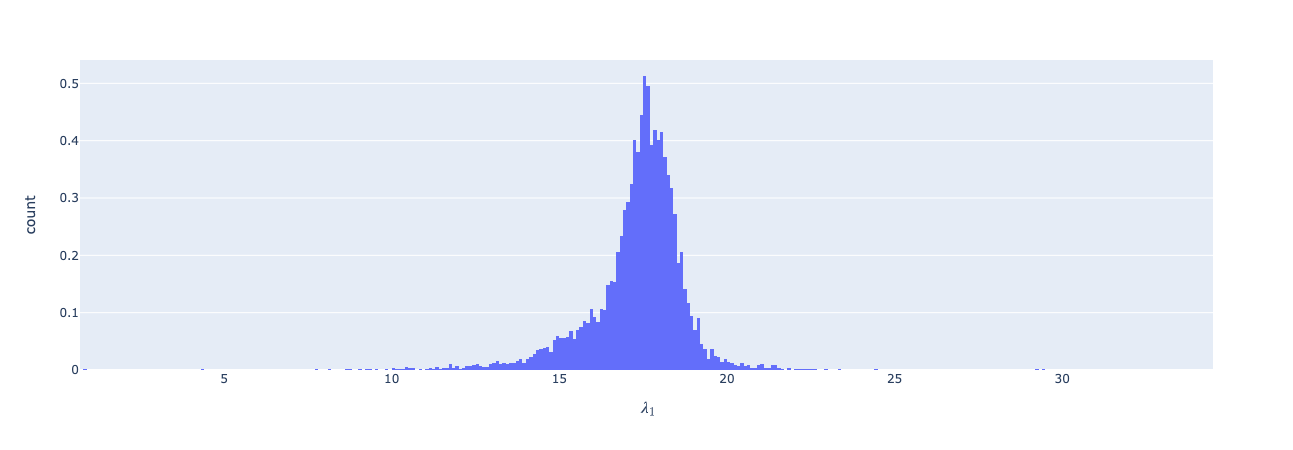

In [128]:
px.histogram(df, x='$\lambda_1$ 값', histnorm='probability density')

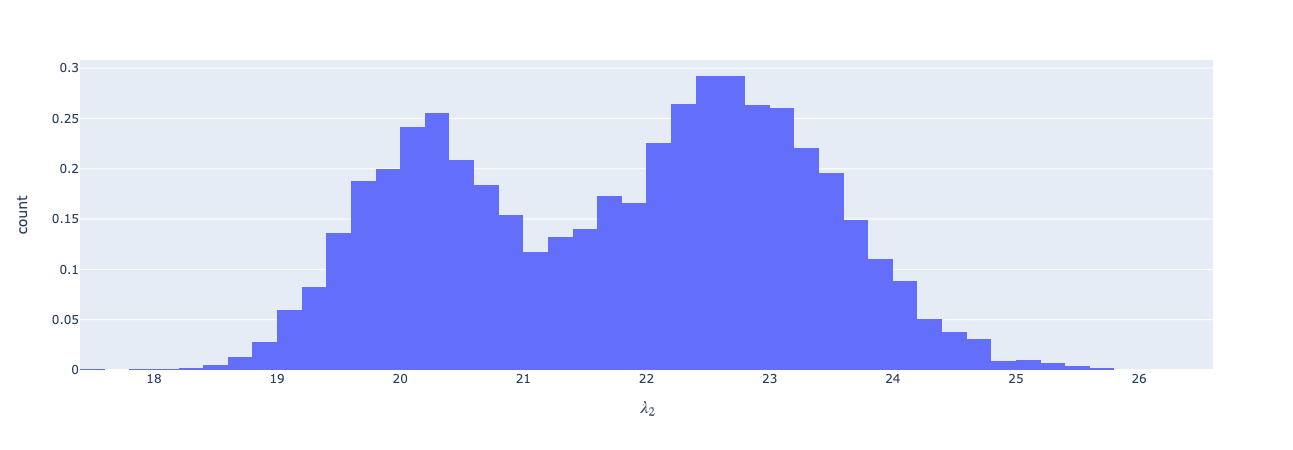

In [131]:
px.histogram(df, x='$\lambda_2$ 값', nbins=50, histnorm='probability density')

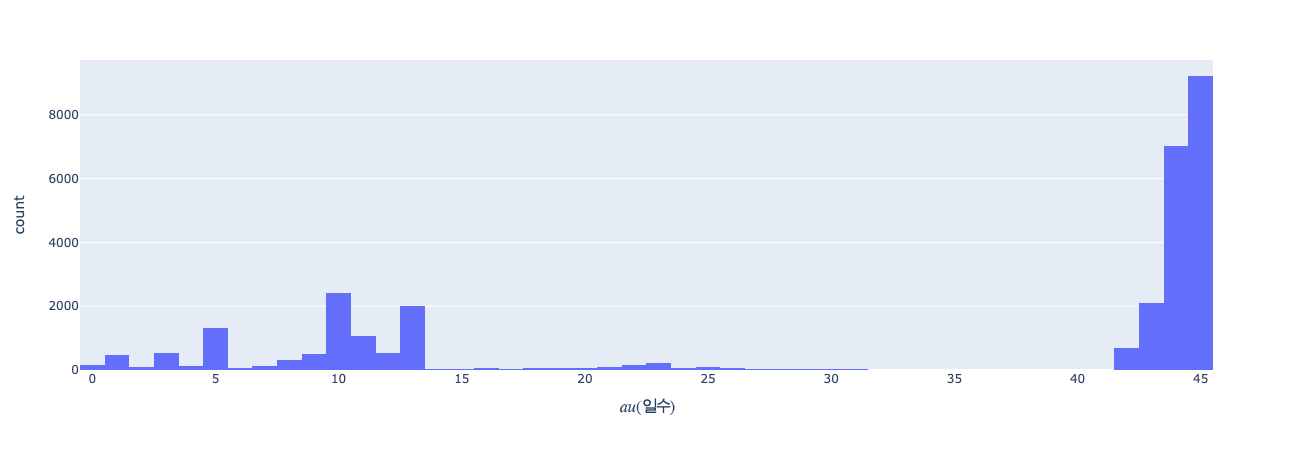

In [120]:
px.histogram(df, x='$\tau(일 수)$')

In [109]:
sampled_lambda_1

array([17.6431343 , 17.84850008, 17.84850008, ..., 17.42765854,
       18.2874372 , 18.2874372 ])

In [107]:
df = px.data.tips()

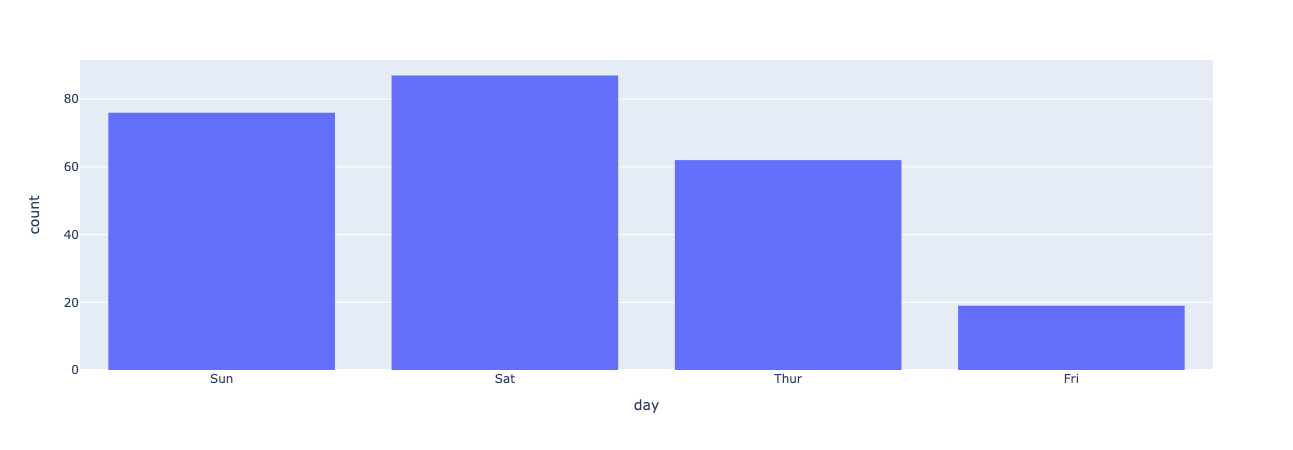

In [108]:
fig = px.histogram(df, x='day')
fig.show()

In [102]:
trace0 = go.Histogram(sampled_lambda_1, xbins=30)
# trace1 = 
# trace2 = 

ValueError: The first argument to the plotly.graph_objs.Histogram 
constructor must be a dict or 
an instance of plotly.graph_objs.Histogram

In [99]:
fig = plotly.subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=[f"lambda_1", 
                                          f"lambda_2",
                                          f"tau"])